<a href="https://colab.research.google.com/github/amkobee/ADS/blob/main/ADS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [24]:
import random
import urllib.request
import os
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import requests
import zipfile
import glob
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub

# Dataset creation
Downloading the photos from Flickr and downloading the photos as a zip. <br>
The images are being downloaded via the FlickrAPI and stored in seperate folders for each class. In order to do that the user must create a public and secret key as described on the Flickr website https://www.flickr.com/services/apps/create/apply/. Add the new values to `FLICKR_PUBLIC` and `FLICKR_SECRET`<br>
The images are stored on GitHub - due to GitHub file size limitations we were only able to store a total of 100 MB. We decided to store around 5000 images with FlickrAPI size "s". <br>
In order to run the function the variable `download_new_photos` must be set to `True`. Additional keywords/classes can be introduced as well and the amount of photos to download can be changed in the variable `TOTAL_PHOTOS`

In [2]:
# set to False to not download new photos
download_new_photos = False

# the keywords to look photos for
keywords = ['sea', 'desert', 'mountain', 'river', 'forest']

# Function to download pictures from Flickr

def download_photos():

    # install and import FlickrAPI package
    !pip install flickrapi
    from flickrapi import FlickrAPI

    # Keys for flickr API
    FLICKR_PUBLIC = '5829447acb20544b640f7c58b058614a'
    FLICKR_SECRET = '856705a9f309b147'

    # Settings (extras = different resolution of photos)
    flickr = FlickrAPI(FLICKR_PUBLIC, FLICKR_SECRET, format='parsed-json')
    extras = 'url_s'

    # how many photos per category
    TOTAL_PHOTOS = 2000
    PHOTOS_PER_PAGE = 500

    cwd = os.getcwd()
    print(f'Photos will be stored at: {cwd}')

    # create photos directory
    try:
        os.mkdir('photos')
        print('Created folder photos')
    except:
        print('Folder "photos" already exists')

    # download the photos per keyword
    for word in keywords:
        # get all photos of the category
        page = 1
        photos = flickr.photos.search(tags=word, text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)

        # create subfolders
        try:
            os.mkdir('photos/'+word)
            print('Created folder ' + word)
        except:
            print(f'Folder "{word}" already exists')

        # download the photos
        j = 1 # index for filenames - won't be reset
        filename = ''
        batch = 1
        total_batch = int(TOTAL_PHOTOS/100)

        while j <= TOTAL_PHOTOS:
            i = random.randint(1, PHOTOS_PER_PAGE-1)
            try:
                url = photos['photos']['photo'][i]['url_s']
            except:
                try:
                  error_photo = photos['photos']['photo'][i]
                  print(f'Error at {error_photo}')
                except:
                  pass

            filename = 'photo_' + str(j) + '.jpg'
            directory = 'photos/' + word + "/" + filename
            urllib.request.urlretrieve(url, directory)
            #print(f'Category {word}: Page {page}; Downloading {j} of {TOTAL_PHOTOS}')
            if j % 100 == 0:
                print(f'Batch {batch} of {total_batch} done')
                batch += 1
            j += 1

            # reached end of page - reset i and increase page
            if j % 500 == 0:
                page += 1
                print('Reached end of page')
                photos = flickr.photos.search(text=word, page=page, per_page=PHOTOS_PER_PAGE, extras=extras, content_type=1)


    print('Finished downloading the photos')
    
    # store all in zip and download
    print('Creating zip file and downloading it')
    !zip -r /content/photos/photos.zip /content/photos
    from google.colab import files
    files.download("/content/photos/photos.zip")

if download_new_photos:
    download_photos()

# Data Exploration
Retrieving the data from GitHub and retrieving example images of the dataset

In [3]:
# Download zip file from GitHub
url = 'https://github.com/amkobee/ADS/raw/main/photos.zip'
r = requests.get(url, allow_redirects=True)

open('photos.zip', 'wb').write(r.content)

# Unzip the file
with zipfile.ZipFile('photos.zip', 'r') as zip_ref:
    zip_ref.extractall()            # folder named "content" will be created

In [4]:
# get the amount of photos
data_dir = '/content/content/photos/'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

5000


In [5]:
# create a dataset containing all information

batch_size = 32
img_height = 180
img_width = 180

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get the class names from the folder names
class_names = full_ds.class_names
print(class_names)

Found 5000 files belonging to 5 classes.
['desert', 'forest', 'mountain', 'river', 'sea']


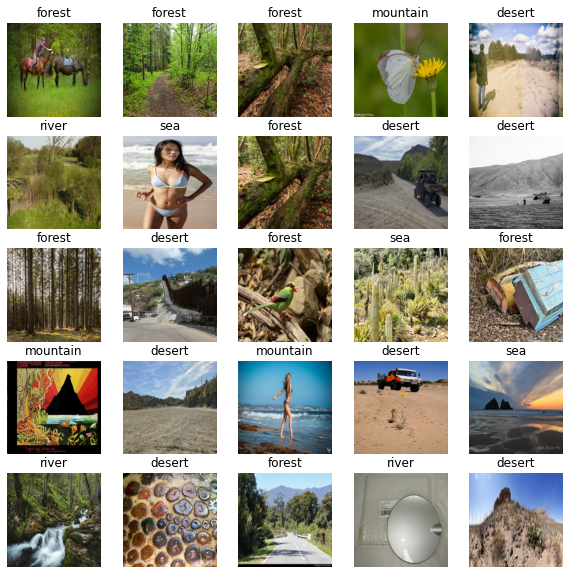

In [6]:
# print some example images
plt.figure(figsize=(10, 10))
for images, labels in full_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Result Discussion

Retrieving the images from a platform where everyone can upload their on images with own tags and descriptions can lead to bad data for our model. <br>
In order to mitigate that risk we introduced randomnes to our fetching function. <br>
With that we want to avoid bad data on one handside on the other we don't want to use mulitple pictures of the same object/landscape uploaded by the same user.

# Data Preparation

In [7]:
# split in training and test set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Found 5000 files belonging to 5 classes.
Using 1000 files for validation.


# Model Creation and Training

Below we will show different iterations of our models <br>
The first model shows our initial setup. The following will show all the modifications that were made during the process

## First training

In [8]:
# set amount of classes to amount of keywords
num_classes = len(keywords)

# define the model
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [9]:
# Train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

# save the model
model.save('landscape_classifier_v1.h5')

Epoch 1/20
125/125 [==============================] - 38s 51ms/step - loss: 1.5594 - accuracy: 0.3405 - val_loss: 1.3633 - val_accuracy: 0.4700
Epoch 2/20
125/125 [==============================] - 6s 51ms/step - loss: 1.2680 - accuracy: 0.4952 - val_loss: 1.2659 - val_accuracy: 0.5200
Epoch 3/20
125/125 [==============================] - 7s 55ms/step - loss: 1.0381 - accuracy: 0.6205 - val_loss: 1.1473 - val_accuracy: 0.5800
Epoch 4/20
125/125 [==============================] - 7s 52ms/step - loss: 0.7227 - accuracy: 0.7483 - val_loss: 1.0071 - val_accuracy: 0.6590
Epoch 5/20
125/125 [==============================] - 7s 55ms/step - loss: 0.4663 - accuracy: 0.8480 - val_loss: 1.0724 - val_accuracy: 0.6800
Epoch 6/20
125/125 [==============================] - 6s 50ms/step - loss: 0.3332 - accuracy: 0.8930 - val_loss: 1.0431 - val_accuracy: 0.7420
Epoch 7/20
125/125 [==============================] - 6s 50ms/step - loss: 0.2421 - accuracy: 0.9235 - val_loss: 1.2454 - val_accuracy: 0.731

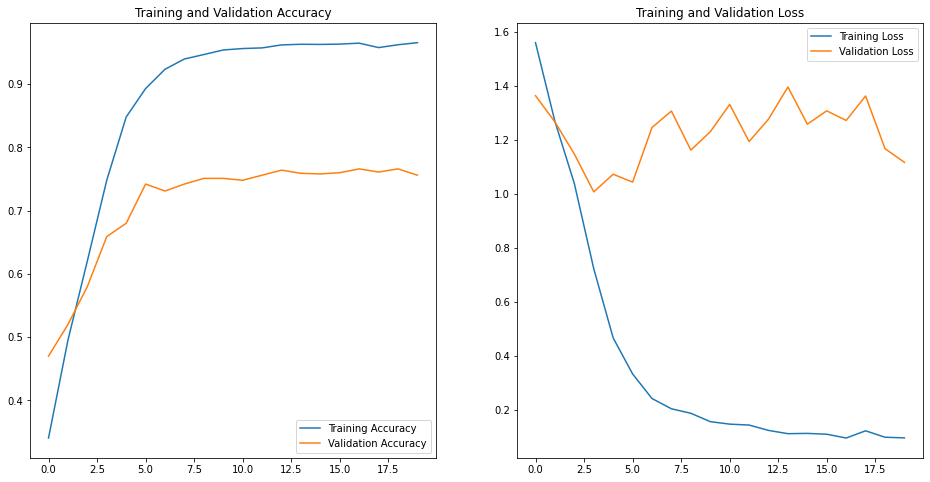

In [10]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Result Discussion

We reached quite a good result on the first try with the training data set. <br>
In accuracy the model performs approx. 20-25% worse with the validation data set. Additionally the difference in loss is extremely high compared to the trainig data set <br>
In order to improve the result for the validation data set we'll introduce **dropout, regularization** and **data augmentation** to the model in the next iteration in order to avoid overfitting.

## Second training

Added dropout and regularization to the model

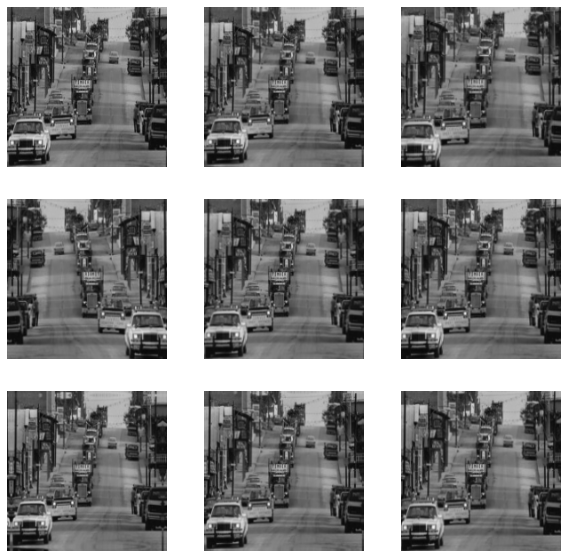

In [18]:
# data augmentation

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

# print an example
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [12]:
# define the model
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
  layers.Dense(num_classes)
])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print summary of the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [13]:
# train the model
epochs=20
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs
)

# save the model
model.save('landscape_classifier_v2.h5')

Epoch 1/20
125/125 [==============================] - 8s 56ms/step - loss: 1.7804 - accuracy: 0.3408 - val_loss: 1.5674 - val_accuracy: 0.3600
Epoch 2/20
125/125 [==============================] - 6s 50ms/step - loss: 1.5470 - accuracy: 0.3920 - val_loss: 1.5178 - val_accuracy: 0.4050
Epoch 3/20
125/125 [==============================] - 7s 53ms/step - loss: 1.5163 - accuracy: 0.4257 - val_loss: 1.4985 - val_accuracy: 0.4360
Epoch 4/20
125/125 [==============================] - 7s 53ms/step - loss: 1.4899 - accuracy: 0.4355 - val_loss: 1.4964 - val_accuracy: 0.4230
Epoch 5/20
125/125 [==============================] - 7s 52ms/step - loss: 1.4799 - accuracy: 0.4490 - val_loss: 1.4817 - val_accuracy: 0.4450
Epoch 6/20
125/125 [==============================] - 6s 49ms/step - loss: 1.4471 - accuracy: 0.4655 - val_loss: 1.4688 - val_accuracy: 0.4580
Epoch 7/20
125/125 [==============================] - 6s 49ms/step - loss: 1.4216 - accuracy: 0.4765 - val_loss: 1.4682 - val_accuracy: 0.4990

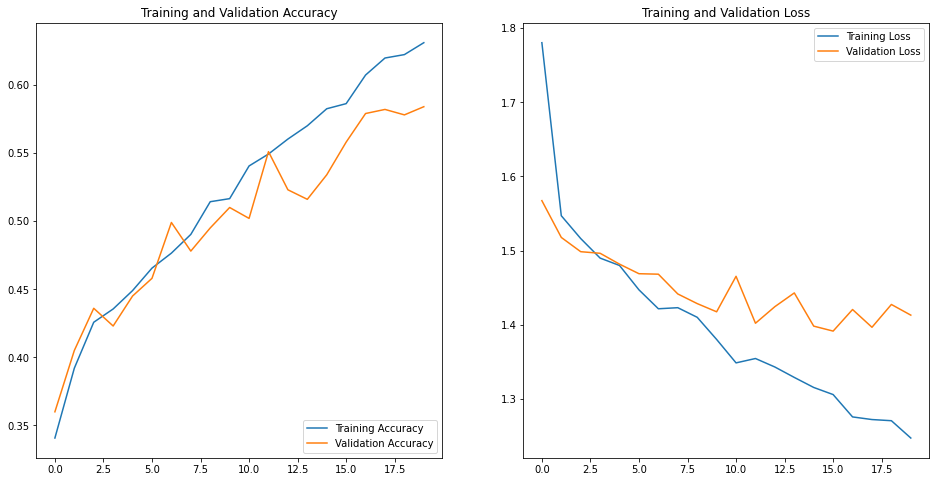

In [14]:
# Visualizing training results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Result Discussion

We were able to reduce the overfitting by introducing dropout and data augmentation. <br>
Instead, we have now a problem with a smaller accuracy. Anyways, we would like to test the performance on "real world" data and compare it with a state of the art model.

# Model testing

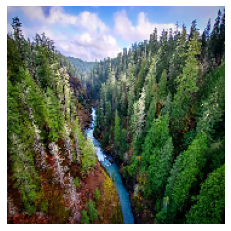

This image most likely belongs to forest with a 85.91 percent confidence.
********************************************


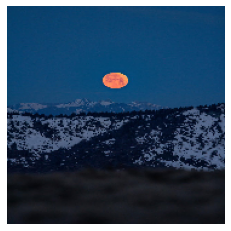

This image most likely belongs to mountain with a 61.89 percent confidence.
********************************************


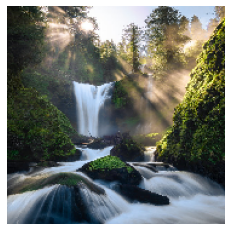

This image most likely belongs to river with a 54.03 percent confidence.
********************************************


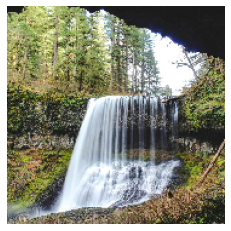

This image most likely belongs to forest with a 94.53 percent confidence.
********************************************


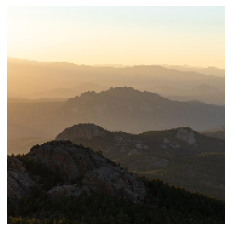

This image most likely belongs to desert with a 41.06 percent confidence.
********************************************


In [17]:
# load the images
img_amount = 5
i = 1

while i <= img_amount:
    try:
        images_path = f'https://github.com/amkobee/ADS/raw/main/scraped_images/test_{i}.png'
        test_image_path = tf.keras.utils.get_file(f'test_{i}.png', origin=images_path)
    except:
        break

    img = keras.preprocessing.image.load_img(
        test_image_path, target_size=(img_height, img_width)
    )

    # print the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # make a prediction
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    print('********************************************')

    i+=1


## Comparison with ResNet V2 50

In [19]:
model_name = "resnet_v2_50" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4
Input size (224, 224)


In [22]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20, horizontal_flip=True, zoom_range=0.5)# add data augmentation trasnformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set

train_generator = train_datagen.flow_from_directory(
    '/content/content/photos/', subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_generator = valid_datagen.flow_from_directory(
    '/content/content/photos/', subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [25]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

In [26]:
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=10, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/10
125/125 [==============================] - 47s 379ms/step - loss: 1.2023 - accuracy: 0.6712 - val_loss: 1.1798 - val_accuracy: 0.6734
Epoch 2/10
125/125 [==============================] - 47s 379ms/step - loss: 1.2254 - accuracy: 0.6610 - val_loss: 1.2383 - val_accuracy: 0.6966
Epoch 3/10
125/125 [==============================] - 47s 377ms/step - loss: 1.1560 - accuracy: 0.6793 - val_loss: 1.1029 - val_accuracy: 0.6956
Epoch 4/10
125/125 [==============================] - 47s 376ms/step - loss: 1.1707 - accuracy: 0.6760 - val_loss: 1.2069 - val_accuracy: 0.6865
Epoch 5/10
125/125 [==============================] - 47s 376ms/step - loss: 1.2039 - accuracy: 0.6672 - val_loss: 1.1795 - val_accuracy: 0.6562
Epoch 6/10
125/125 [==============================] - 47s 376ms/step - loss: 1.1825 - accuracy: 0.6745 - val_loss: 1.2241 - val_accuracy: 0.6704
Epoch 7/10
125/125 [==============================] - 47s 379ms/step - loss: 1.1787 - accuracy: 0.6705 - val_loss: 1.2055 - val_ac

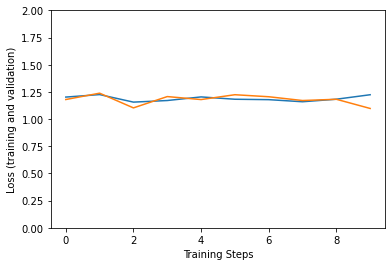

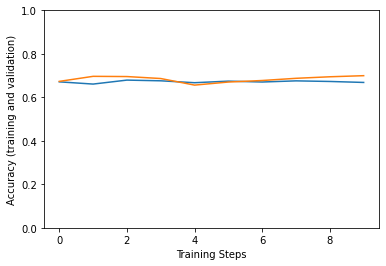

In [37]:
# Visualizing training results

plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

### Result Discussion
The ResNet V2 50 model outperforms our model by approx. 10-15% in accuracy. Also, the training and validation are much closer to each other than in our model<br>
Still, our model uses almost 10 times less layers.


